
Reviews Usefulness using Gated Recurrent Unit

Afifa Tariq

--------------------------------


Import Libraries

In [1]:
import pandas as pd
import numpy as np
!pip install langdetect
from langdetect import detect
import re
from nltk.corpus import stopwords
import tensorflow as tf
from sklearn.model_selection import train_test_split

Authenticate with your google account

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Download yelp_review.csv file from google drive

In [0]:
link = 'https://drive.google.com/open?id=1H-XN57SmGOgjXb7xNDaaAB8UpGeIRHpS' # The shareable link
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('yelp_review.csv')


Read csv file in pandas


In [0]:
reviews = pd.read_csv('yelp_review.csv')

In [4]:
useful = reviews.loc[reviews['useful'] >40]
useful.shape

(3921, 9)

In [0]:
usefulNew = useful[:50]
usefulNew.to_csv('veryUseful.csv')

In [6]:
usefulReviews = reviews
usefulReviews.loc[usefulReviews.useful >=1, 'useful'] = 1
usefulReviews.head()
print(usefulReviews.shape)

(5261668, 9)


Function to clean the reviews from punctuations, stopwords, etc.



In [0]:
def clean_text(text):
    text = text.lower()    
    if True:
        text = text.split()
        new_text = []
        for word in text:
            new_text.append(word)
        text = " ".join(new_text)
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

Applying cleantext function to all the reviews.

This function takes a long time to run, so when I am just checking if my code is working, I keep the num = 50000. Otherwise, it should be num=5000000.

In [8]:
import nltk
nltk.download('stopwords')
revs_list = [[]]
useful_list = [[]]
num = 50000 # Number of review read
k = 0 # Count
nolang = [[]]
for index, row in usefulReviews.iterrows():
    if k >= num:
        break
    review = row['text']
    usefulCount = row.useful
    try:
      if detect(review) == 'en':
          revs_list.append(clean_text(review))
          useful_list.append(usefulCount)
          k += 1
          # Notify for every 5000 reviews
          if len(revs_list) % 5000 == 0:
              print(len(revs_list), k)
    except:
      print("This row throws error:", row)
      print(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
5000 4999
10000 9999
15000 14999
20000 19999
25000 24999
30000 29999
35000 34999
40000 39999
45000 44999
50000 49999


Check what review looks like after cleaning

In [9]:
print(revs_list[1])
print(len(revs_list), len(useful_list))

super simple place amazing nonetheless around since 30 still serve thing started bologna salami sandwich mustard staff helpful friendly
50001 50001


Converting our cleaned reviews to pandas dataframe

In [10]:
np_revs = np.asarray([revs_list]).T
np_useful = np.asarray([useful_list]).T
stacked_revs = np.hstack((np_revs, np_useful))
categories = ['text', 'useful']
df_reviews_processing = pd.DataFrame(stacked_revs, columns=categories)
df_reviews_processing = df_reviews_processing.iloc[1:, :]
print(df_reviews_processing.shape)
print(df_reviews_processing.head())

(50000, 2)
                                                text useful
1  super simple place amazing nonetheless around ...      0
2  small unassuming place changes menu every ofte...      0
3  lester located beautiful neighborhood since 19...      0
4  love coming yes place always needs floor swept...      0
5  chocolate almond croissant amazing light butte...      0


Count the number of unique words in the vocabulary and assign an integer to them. Sort them from highest frequency to lowest so that the words used more often are given a smaller integer value.

In [0]:
from collections import Counter

all_text2 = ' '.join(str(v) for v in df_reviews_processing.text)
# create a list of words
words = all_text2.split()
# Count all the words using Counter Method
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)

In [0]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}


Convert all reviews based on integer assigned to word

In [13]:
seq = []
for review in df_reviews_processing.text:
  try:
    r = [vocab_to_int[w] for w in review.split()]
    seq.append(r)

  except:
    print(review)
print (seq[0:3])

[[120, 486, 2, 54, 2536, 71, 76, 287, 60, 450, 113, 331, 13298, 4332, 164, 1697, 25, 257, 30], [87, 4822, 2, 1633, 41, 90, 445, 244, 398, 732, 167, 287, 697, 38, 215, 726, 204, 3597, 231, 1112, 359, 539, 165, 857, 110, 3192, 70, 829, 39, 12, 3332, 1965, 544, 13, 43, 228, 54, 708, 123, 12, 79, 261, 652, 1485, 66, 2929, 279, 131, 601, 276, 949], [19651, 528, 380, 807, 76, 34178, 1135, 1203, 148, 1574, 1199, 164, 35, 1485, 17, 610, 784, 261, 12, 531, 167, 1203, 148, 135, 138, 10261, 94, 279, 3732, 19651, 19]]


Check review length

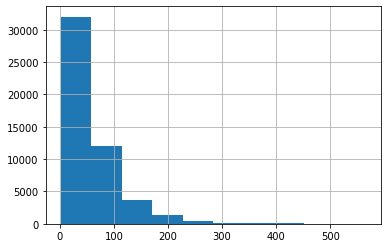

count    50000.000000
mean        59.543340
std         53.447486
min          2.000000
25%         24.000000
50%         43.000000
75%         76.000000
max        565.000000
dtype: float64

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
reviews_len = [len(x) for x in seq]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [0]:
usefuls = df_reviews_processing.useful.values.astype(int)
reviews_int = [ seq[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_labels = [ usefuls[i] for i, l in enumerate(reviews_len) if l> 0 ]

Convert all reviews to same length

In [0]:
def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

In [17]:
features = pad_features(reviews_int, 100)
features.shape

(50000, 100)

Divide data into three sets: Training, Test, Validation

In [0]:
split_frac = 0.8

train_x = features[0:int(split_frac*len(reviews_len))]
train_y = encoded_labels[0:int(split_frac*len(reviews_len))]
remaining_x = features[int(split_frac*len(reviews_len)):]
remaining_y = encoded_labels[int(split_frac*len(reviews_len)):]
valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]
test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]

In [0]:
import torch
from torch.utils.data import DataLoader, TensorDataset
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(np.asarray(train_x)), torch.from_numpy(np.asarray(train_y)))
valid_data = TensorDataset(torch.from_numpy(np.asarray(valid_x)), torch.from_numpy(np.asarray(valid_y)))
test_data = TensorDataset(torch.from_numpy(np.asarray(test_x)), torch.from_numpy(np.asarray(test_y)))
# dataloaders
batch_size = 50
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [20]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 100])
Sample input: 
 tensor([[    0,     0,     0,  ...,  1118,     4,     9],
        [    0,     0,     0,  ...,    18,   382,  4045],
        [ 2683,   244, 28751,  ...,  6845,   398,    79],
        ...,
        [    0,     0,     0,  ...,   456,   166,    28],
        [    0,     0,     0,  ...,  1037,    63,   466],
        [    8,    53,  1393,  ...,   168,     5,   155]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 1])


Create GRU model class

In [0]:
import torch.nn as nn

class GRU(nn.Module):

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and GRU layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and gru_out
        embeds = self.embedding(x)
        gru_out, hidden = self.gru(embeds, hidden)
    
        # stack up gru outputs
        gru_out = gru_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(gru_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda()
        else:
            hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        
        return hidden

In [22]:
# Instantiate the model w/ hyperparams
vocab_size = len(count_words)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2
net = GRU(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

GRU(
  (embedding): Embedding(58755, 400)
  (gru): GRU(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [0]:
train_on_gpu = True

Training

In [24]:
# loss and optimization functions
lr=0.001
losses = []
validation_losses = []


# training params

epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing


counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
  net = net.cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        #h = tuple([each.data for each in h])
        h = h.data

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        inputs = inputs.type(torch.LongTensor)
        if(train_on_gpu):
          inputs, labels = inputs.cuda(), labels.cuda()
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                #val_h = tuple([each.data for each in val_h])
                val_h = val_h.data
                
                inputs = inputs.type(torch.LongTensor)
                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            losses.append(loss.item())
            validation_losses.append(np.mean(val_losses))
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/4... Step: 100... Loss: 0.232735... Val Loss: 0.233733
Epoch: 1/4... Step: 200... Loss: 0.203573... Val Loss: 0.230871
Epoch: 1/4... Step: 300... Loss: 0.265269... Val Loss: 0.230516
Epoch: 1/4... Step: 400... Loss: 0.178806... Val Loss: 0.233915
Epoch: 1/4... Step: 500... Loss: 0.190112... Val Loss: 0.237928
Epoch: 1/4... Step: 600... Loss: 0.199465... Val Loss: 0.231032
Epoch: 1/4... Step: 700... Loss: 0.197887... Val Loss: 0.229321
Epoch: 1/4... Step: 800... Loss: 0.244423... Val Loss: 0.229442
Epoch: 2/4... Step: 900... Loss: 0.194067... Val Loss: 0.232102
Epoch: 2/4... Step: 1000... Loss: 0.216917... Val Loss: 0.236124
Epoch: 2/4... Step: 1100... Loss: 0.210297... Val Loss: 0.235378
Epoch: 2/4... Step: 1200... Loss: 0.216260... Val Loss: 0.232461
Epoch: 2/4... Step: 1300... Loss: 0.218003... Val Loss: 0.236638
Epoch: 2/4... Step: 1400... Loss: 0.247009... Val Loss: 0.233564
Epoch: 2/4... Step: 1500... Loss: 0.217630... Val Loss: 0.233221
Epoch: 2/4... Step: 1600... Loss: 

Testing

In [25]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h=h.data
    
    # get predicted outputs
    inputs = inputs.type(torch.LongTensor)
    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.277
Test accuracy: 0.606


Preprocessing for testing review

In [0]:
def tokenize_review(test_review):
   
    pred_text = clean_text(test_review)
    #pred_seq = convert_to_ints(pred_text, pred=True)
    test_words = pred_text.split()
    
    # tokens
    test_ints = []
    test_ints.append([vocab_to_int[word] for word in test_words])

    return test_ints


In [0]:
def predict(net, test_review, sequence_length=100):
    
    net.eval()
    
    # tokenize review
    test_ints = tokenize_review(test_review)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    # initialize hidden state
    h = net.init_hidden(batch_size)
    
    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()
    
    # get the output from the model
    output, h = net(feature_tensor, h)
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze()) 
    # printing output value, before rounding
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    
    # print custom response
    if(pred.item()==1):
        print("Useful review detected!")
    else:
        print("Not useful review detected.")

In [38]:
# test code and generate tokenized review
test_review = input("Please enter a review in English: \n")
seq_length=100 
predict(net, test_review, seq_length)

Please enter a review in English: 
Not bad!! Love that there is a gluten-free, vegan version of the cheese curds and gravy!! Haven't done the poutine taste test yet with smoke's but Im excited to see which is better. However poutini's might win as they are vegan and gluten-free
Prediction value, pre-rounding: 0.871396
Useful review detected!
